In [1]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import*

In [2]:
def R(theta):
    return array([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]])

def SO2_from_params(theta, x, y):
    return array([
        [cos(theta), -sin(theta), x],
        [sin(theta), cos(theta), y],
        [0, 0, 1]])

def SO2_wedge(v):
    return array([
        [0, -v[0], v[1]],
        [v[0], 0, v[2]],
        [0, 0, 1]])

def SO2_vee(a):
    return array([a[1,0], a[0,2], a[1,2]])

def SO2_exp(a):
    alpha = a[0]
    u1 = a[1]
    u2 = a[2]
    if alpha < pi/18:
        t1 = 1 - alpha**2/6 + alpha**4/120
        t2 = alpha/2 - alpha**3/24 - alpha**5/720
    else:
        t1 = sin(alpha)/alpha
        t2 = 1-cos(alpha)/alpha
    x = array([[t1, -t2],
               [t2, t1]])@[[u1],[u2]]
    return SO2_from_params(alpha, x[0][0], x[1][0])

In [3]:
def iekf(t, vt, x0, P0, dt, Xi0):
    
    theta = x0[0]
    x1 = x0[1]
    x2 = x0[2]
    # left invariant error in exponential coordinate
    X = SO2_from_params(x0[0], x0[1], x0[2])
    
    # Initial Condition
    X_h = SO2_from_params(x0[0]-Xi0[0], x0[1], x0[2])
    P = P0
    Xi = Xi0.reshape(3,1)
    
    step = int(t/dt)
    
    v = vt[0] # velocity measured by an odometer
    w = vt[1] # velocity measured through differential odometry
    
    Out_X = []
    Out_Xi = []
    Out_Xe = []
    Out_ita = []
    
    for i in range(step):
        
        Q = diag([1,1e-4,1e-4])
        w_noise = np.random.multivariate_normal(zeros(3), sqrt(Q))
        w_theta = w_noise[0] # differential odometry error
        w_l = w_noise[1] # longitudinal odometry error
        w_tr = w_noise[2] # the transversal shift
        
        A = -array([[0, 0, 0],
                    [0, 0, -w],
                    [-v, w, 0]])
        vt = array([[0, -w, v],
                    [w, 0, 0],
                    [0, 0, 0]])
        wt = array([[0, -w_theta, w_l],
                    [w_theta, 0, w_tr],
                    [0, 0, 0]])
        
        # Reference Trajectory
        V = SO2_vee(vt)
        M = SO2_exp(V*dt)
        X = X@SO2_exp(V*dt)
        Out_X.append(X)
        
        # Propagation
        if i%(1/dt) == 0:
            dXi = A@Xi - w_noise.reshape(3,1)
        else:
            dXi = A@Xi
        dX_h = X_h@vt
        Xi = Xi + dXi*dt
        X_h = X_h + dX_h*dt

        # Covariance Propagation
        dP = (A@P+P@A.T+Q)*dt
        P = P+dP
        
        #iekf Gain
        Vn_cov = 1e-2*eye(2)
        Vn = np.random.multivariate_normal(zeros(2), sqrt(Vn_cov))
        H = array([[0, 1, 0],
                   [0, 0, 1]])
        R = X_h[0:2,0:2]
        N = R@Vn_cov@R.T
        S = H@P@H.T + N
        Ln = P@H.T@inv(S) # Gain
        
        # Measurement
        if i%(0.01/dt) ==0:
            Y = X.dot(array([[0, 0, 1]]).T) + np.append(Vn,[0]).reshape(3,1)
        else:
            Y = X.dot(array([[0, 0, 1]]).T)

        # update
        # updated invariant error in exp coordinate
        Xi = Xi - Ln@(array([[0,1,0],[0,0,1]])@Xi - R@Vn.reshape(2,1))
        # updated invariant error
        ita = SO2_exp(Xi.reshape(3,))
        # updated states
        X_h = X@ita
        
        Out_Xi.append(Xi)
        Out_Xe.append(X_h)
        Out_ita.append(ita)
           
    return Out_Xi, Out_Xe, Out_X, Out_ita

In [4]:
t = 40
vt = [.7, .14]
x0 = [pi/2,0,0]
Xi0 = array([pi/4,0,0]).T # initial error
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.01
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt, Xi0)

# Figure 1

In [5]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

In [6]:
m = 10
e_x = []
e_y = []
r_x = []
r_y = []
for j in range(int(len(xe_x)/m)-1):
    xe_x_avg = sum(xe_x[j*10:(j+1)*m])/m
    e_x.append(xe_x_avg)
    xe_y_avg = sum(xe_y[j*10:(j+1)*m])/m
    e_y.append(xe_y_avg)
    xr_x_avg = sum(xr_x[j*10:(j+1)*m])/m
    r_x.append(xr_x_avg)
    xr_y_avg = sum(xr_y[j*10:(j+1)*m])/m
    r_y.append(xr_y_avg)

(-0.5, 509.5, 413.5, -0.5)

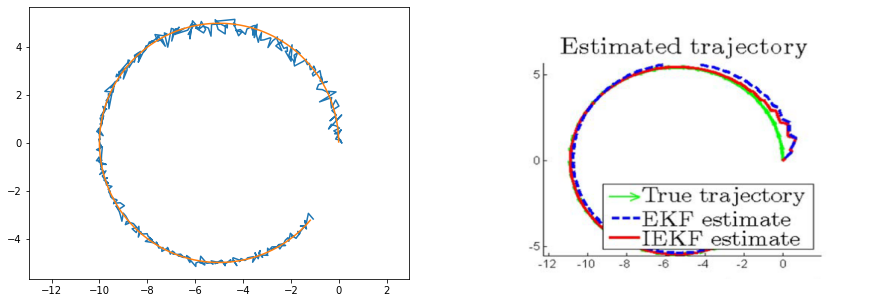

In [7]:
figure(figsize=(15,5))
subplot(121)
plot(e_x,e_y, label='estimated')
plot(r_x,r_y, label = 'reference')
axis('equal');
subplot(122)
imshow(imread('./images/fig1.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 2

In [8]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

In [9]:
err_att = []
windowsize = 100
for j in range(len(error_att) - windowsize +1):
    err_att_avg = sum(error_att[j:j+windowsize])/windowsize
    err_att.append(err_att_avg)

(-0.5, 509.5, 413.5, -0.5)

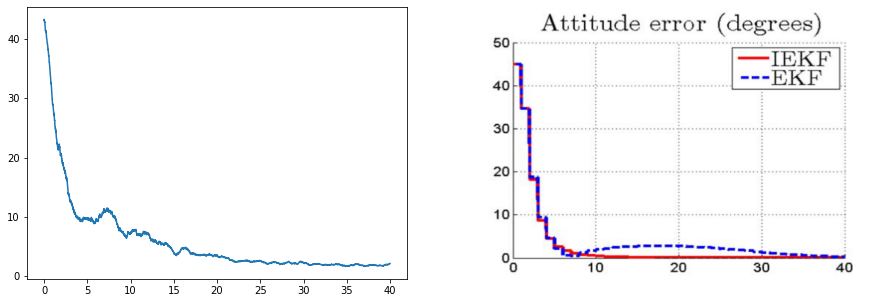

In [10]:
t_x = np.linspace(0, t, len(err_att))
figure(figsize=(15,5))
subplot(121)
plot(t_x, err_att)
subplot(122)
imshow(imread('./images/fig2.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 3

In [11]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

In [12]:
err = []
for j in range(len(error) - windowsize +1):
    err_avg = sum(error[j:j+windowsize])/windowsize
    err.append(err_avg)

(-0.5, 509.5, 413.5, -0.5)

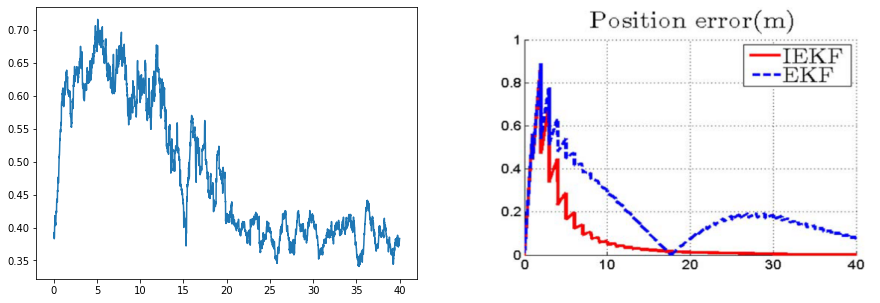

In [13]:
figure(figsize=(15,5))
subplot(121)
plot(t_x ,err)
subplot(122)
imshow(imread('./images/fig3.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [14]:
t = 40
vt = [.7, .14]
x0 = [pi/2,0,0]
Xi0 = array([pi/180,0,0]).T # initial error
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.01
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt, Xi0)

# Figure 4

In [15]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

In [16]:
m = 10
e_x = []
e_y = []
r_x = []
r_y = []
for j in range(int(len(xe_x)/m)-1):
    xe_x_avg = sum(xe_x[j*10:(j+1)*m])/m
    e_x.append(xe_x_avg)
    xe_y_avg = sum(xe_y[j*10:(j+1)*m])/m
    e_y.append(xe_y_avg)
    xr_x_avg = sum(xr_x[j*10:(j+1)*m])/m
    r_x.append(xr_x_avg)
    xr_y_avg = sum(xr_y[j*10:(j+1)*m])/m
    r_y.append(xr_y_avg)

(-0.5, 387.5, 317.5, -0.5)

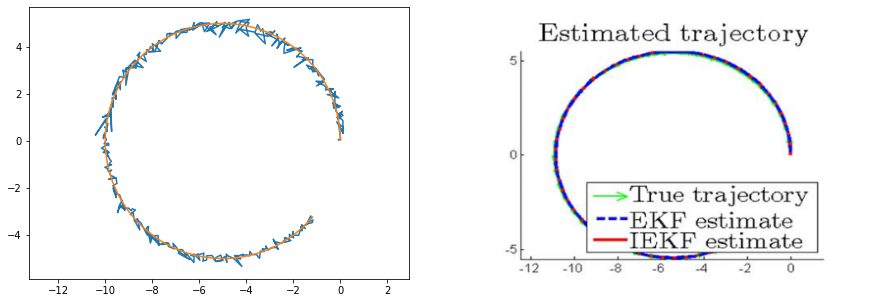

In [19]:
figure(figsize=(15,5))
subplot(121)
plot(e_x,e_y, label='estimated')
plot(r_x,r_y, label = 'reference')
axis('equal');
subplot(122)
imshow(imread('./images/fig4.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 5

In [20]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

In [21]:
err_att = []
windowsize = 100
for j in range(len(error_att) - windowsize +1):
    err_att_avg = sum(error_att[j:j+windowsize])/windowsize
    err_att.append(err_att_avg)

(-0.5, 435.5, 341.5, -0.5)

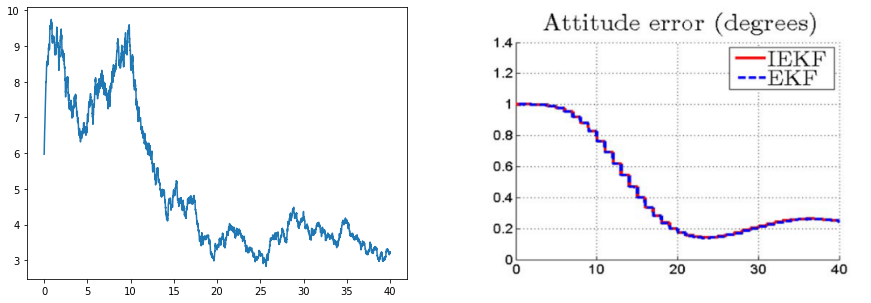

In [24]:
t_x = np.linspace(0, t, len(err_att))
figure(figsize=(15,5))
subplot(121)
plot(t_x, err_att)
subplot(122)
imshow(imread('./images/fig5.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

# Figure 6

In [25]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

In [26]:
err = []
for j in range(len(error) - windowsize +1):
    err_avg = sum(error[j:j+windowsize])/windowsize
    err.append(err_avg)

(-0.5, 435.5, 341.5, -0.5)

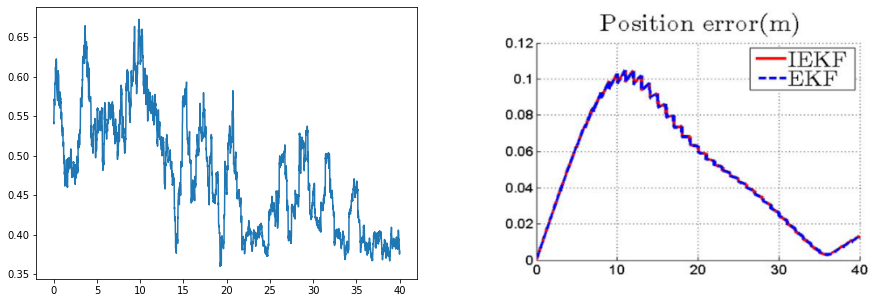

In [28]:
figure(figsize=(15,5))
subplot(121)
plot(t_x ,err)
subplot(122)
imshow(imread('./images/fig6.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')